In [1]:
# load everything from explore notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# run the explore notebook first if data not loaded
# %run explore.ipynb

# load dependent objects
df_health = pd.read_pickle('.objects/healthcare_access_scores.pkl')
df_health_clean = pd.read_pickle('.objects/healthcare_access_scores_clean.pkl')

In [2]:
# quick check what we have
print(f"Counties: {len(df_health)}")
print(f"Features: {df_health.columns.tolist()[-10:]}")
print(f"Healthcare scores range: {df_health['Healthcare_Access'].min():.1f} - {df_health['Healthcare_Access'].max():.1f}")

df_health.describe()[['Healthcare_Access', 'Insurance_Rate', 'Poverty_Rate', 'Education_Rate']].round(2)

Counties: 3222
Features: ['Insurance_Rate', 'Education_Rate', 'Income_Normalized', 'Commute_Score', 'No_Vehicle_Rate', 'Poverty_Rate', 'Disability_Rate', 'Healthcare_Access_Classic', 'Healthcare_Access', 'Score_Diff']
Healthcare scores range: 41.1 - 94.8


,Healthcare_Access,Insurance_Rate,Poverty_Rate,Education_Rate
count,3222.00,3222.00,3222.00,3222.00
mean,52.17,97.55,14.99,10.86
std,9.59,3.82,7.63,4.22
min,41.14,44.80,1.70,0.00
25%,45.80,97.83,10.06,7.81
50%,48.70,98.74,13.41,10.14
75%,53.24,99.17,17.83,13.26
max,94.82,100.00,64.75,37.20


In [3]:
# insurance coverage model
insurance_features = ['Population', 'Median_Income', 'Education_Rate', 'Poverty_Rate', 
                     'Owner_Occupied', 'Commute_Minutes']

X_ins = df_health[insurance_features].fillna(0)
y_ins = df_health['Insurance_Rate'].fillna(0)

X_ins_train, X_ins_test, y_ins_train, y_ins_test = train_test_split(X_ins, y_ins, test_size=0.2, random_state=42)

rf_insurance = RandomForestRegressor(n_estimators=100, random_state=42)
rf_insurance.fit(X_ins_train, y_ins_train)

ins_pred = rf_insurance.predict(X_ins_test)
print(f"Insurance model MAE: {mean_absolute_error(y_ins_test, ins_pred):.2f}")
print(f"Insurance model R²: {r2_score(y_ins_test, ins_pred):.3f}")

ins_importance = pd.DataFrame({
    'feature': insurance_features,
    'importance': rf_insurance.feature_importances_
}).sort_values('importance', ascending=False)
print("\nInsurance drivers:")
print(ins_importance)

Insurance model MAE: 2.03
Insurance model R²: 0.104

Insurance drivers:
           feature  importance
0       Population    0.217198
2   Education_Rate    0.214948
4   Owner_Occupied    0.164831
1    Median_Income    0.137350
5  Commute_Minutes    0.136906
3     Poverty_Rate    0.128768


In [4]:
# poverty model
poverty_features = ['Population', 'Median_Income', 'Education_Rate', 'Owner_Occupied', 
                   'Commute_Minutes', 'No_Vehicle_Rate', 'Disability_Rate']

X_pov = df_health[poverty_features].fillna(0)
y_pov = df_health['Poverty_Rate'].fillna(0)

# remove outliers - some counties have weird poverty rates
poverty_mask = (y_pov <= 60) & (y_pov >= 0)  # reasonable poverty range
X_pov = X_pov[poverty_mask]
y_pov = y_pov[poverty_mask]

X_pov_train, X_pov_test, y_pov_train, y_pov_test = train_test_split(X_pov, y_pov, test_size=0.2, random_state=42)

rf_poverty = RandomForestRegressor(n_estimators=150, random_state=42)
rf_poverty.fit(X_pov_train, y_pov_train)

pov_pred = rf_poverty.predict(X_pov_test)
print(f"Poverty model MAE: {mean_absolute_error(y_pov_test, pov_pred):.2f}")
print(f"Poverty model R²: {r2_score(y_pov_test, pov_pred):.3f}")

pov_importance = pd.DataFrame({
    'feature': poverty_features,
    'importance': rf_poverty.feature_importances_
}).sort_values('importance', ascending=False)
print("\nPoverty drivers:")
print(pov_importance)

Poverty model MAE: 2.23
Poverty model R²: 0.819

Poverty drivers:
           feature  importance
1    Median_Income    0.810978
5  No_Vehicle_Rate    0.042945
6  Disability_Rate    0.036100
0       Population    0.029935
2   Education_Rate    0.029879
3   Owner_Occupied    0.029844
4  Commute_Minutes    0.020319


In [5]:
# education model
education_features = ['Population', 'Median_Income', 'Poverty_Rate', 'Owner_Occupied', 'Commute_Minutes']

X_edu = df_health[education_features].fillna(0)
y_edu = df_health['Education_Rate'].fillna(0)

# education rates can be weird too - cap at reasonable levels
edu_mask = (y_edu <= 80) & (y_edu >= 0)
X_edu = X_edu[edu_mask]
y_edu = y_edu[edu_mask]

X_edu_train, X_edu_test, y_edu_train, y_edu_test = train_test_split(X_edu, y_edu, test_size=0.2, random_state=42)

rf_education = RandomForestRegressor(n_estimators=120, random_state=42)
rf_education.fit(X_edu_train, y_edu_train)

edu_pred = rf_education.predict(X_edu_test)
print(f"Education model MAE: {mean_absolute_error(y_edu_test, edu_pred):.2f}")
print(f"Education model R²: {r2_score(y_edu_test, edu_pred):.3f}")

edu_importance = pd.DataFrame({
    'feature': education_features,
    'importance': rf_education.feature_importances_
}).sort_values('importance', ascending=False)
print("\nEducation drivers:")
print(edu_importance)

Education model MAE: 2.20
Education model R²: 0.531

Education drivers:
           feature  importance
1    Median_Income    0.569486
2     Poverty_Rate    0.133258
3   Owner_Occupied    0.113891
4  Commute_Minutes    0.098265
0       Population    0.085100


In [6]:
# income prediction
income_features = ['Population', 'Education_Rate', 'Poverty_Rate', 'Owner_Occupied', 
                  'Commute_Minutes', 'No_Vehicle_Rate']

X_inc = df_health[income_features].fillna(0)
y_inc = df_health['Median_Income'].fillna(0)

# remove extreme outliers in income
inc_mask = (y_inc <= 200000) & (y_inc >= 20000)
X_inc = X_inc[inc_mask]
y_inc = y_inc[inc_mask]

X_inc_train, X_inc_test, y_inc_train, y_inc_test = train_test_split(X_inc, y_inc, test_size=0.2, random_state=42)

rf_income = RandomForestRegressor(n_estimators=200, random_state=42)
rf_income.fit(X_inc_train, y_inc_train)

inc_pred = rf_income.predict(X_inc_test)
print(f"Income model MAE: ${mean_absolute_error(y_inc_test, inc_pred):,.0f}")
print(f"Income model R²: {r2_score(y_inc_test, inc_pred):.3f}")

inc_importance = pd.DataFrame({
    'feature': income_features,
    'importance': rf_income.feature_importances_
}).sort_values('importance', ascending=False)
print("\nIncome drivers:")
print(inc_importance)

Income model MAE: $5,727
Income model R²: 0.820

Income drivers:
           feature  importance
2     Poverty_Rate    0.655104
1   Education_Rate    0.129939
4  Commute_Minutes    0.081815
0       Population    0.053788
5  No_Vehicle_Rate    0.045624
3   Owner_Occupied    0.033730


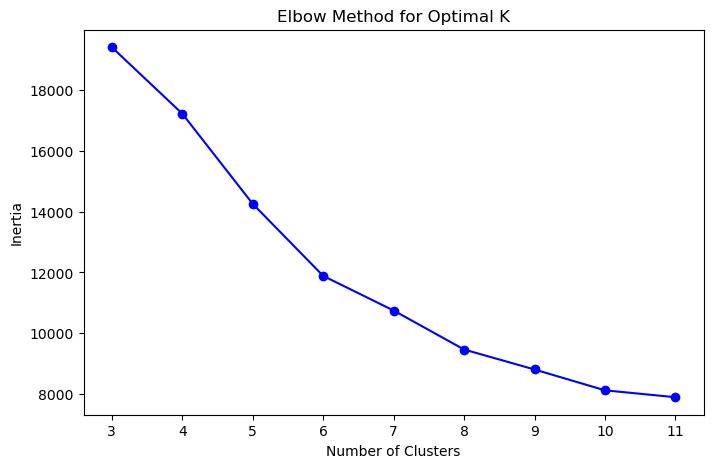

Cluster distribution:
Cluster
0     523
1     179
2      19
3     175
4       2
5    1300
6    1024
Name: count, dtype: int64


In [7]:
# cluster counties by their characteristics
cluster_features = ['Population', 'Median_Income', 'Education_Rate', 'Insurance_Rate', 
                   'Poverty_Rate', 'No_Vehicle_Rate', 'Disability_Rate', 'Healthcare_Access']

cluster_data = df_health[cluster_features].fillna(df_health[cluster_features].median())

# standardize for clustering
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

# try different k values
inertias = []
k_range = range(3, 12)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# use 7 clusters
kmeans_final = KMeans(n_clusters=7, random_state=42)
df_health['Cluster'] = kmeans_final.fit_predict(cluster_scaled)

print(f"Cluster distribution:")
print(df_health['Cluster'].value_counts().sort_index())

In [8]:
# analyze cluster characteristics
cluster_summary = df_health.groupby('Cluster')[cluster_features].mean().round(1)
print("Cluster characteristics:")
print(cluster_summary)

# give clusters meaningful names based on their characteristics
cluster_names = {
    0: "Rural Low-Income",
    1: "Suburban Middle-Class", 
    2: "Urban Diverse",
    3: "Wealthy Metro",
    4: "Small Towns",
    5: "Rural Disadvantaged",
    6: "College Towns"
}

df_health['Cluster_Name'] = df_health['Cluster'].map(cluster_names)

# quick validation - check some examples
for cluster in range(7):
    examples = df_health[df_health['Cluster'] == cluster][['County', 'State', 'Healthcare_Access']].head(3)
    print(f"\n{cluster_names[cluster]} examples:")
    for _, row in examples.iterrows():
        print(f"  {row['County']}, {row['State']} (Score: {row['Healthcare_Access']:.1f})")

Cluster characteristics:
         Population  Median_Income  Education_Rate  Insurance_Rate  \
Cluster                                                              
0          457293.5        85886.6            15.7            98.7   
1           33077.9        33576.3             9.5            98.3   
2          669464.4        78931.0            11.9            99.2   
3           24165.3        55052.5             7.4            84.4   
4             507.0   -666666666.0            11.4            99.6   
5           36083.9        56587.5             8.2            98.0   
6           26072.4        72093.5            12.6            98.5   

         Poverty_Rate  No_Vehicle_Rate  Disability_Rate  Healthcare_Access  
Cluster                                                                     
0                10.7              5.8             49.1               70.5  
1                36.7             11.8             47.7               45.0  
2                17.3             46

In [9]:
def simulate_insurance_change(county_fips, change_pct):
    """simulate insurance rate change for a county"""
    county = df_health[df_health['FIPS'] == county_fips].iloc[0]
    
    # current values
    current_insurance = county['Insurance_Rate']
    new_insurance = np.clip(current_insurance * (1 + change_pct/100), 0, 100)
    
    # recalculate healthcare access with new insurance rate
    new_score = (
        new_insurance * 0.25 +
        county['Education_Rate'] * 0.15 +
        county['Income_Normalized'] * 100 * 0.15 +
        (100 - county['Poverty_Rate']) * 0.15 +
        (100 - county['No_Vehicle_Rate']) * 0.10 +
        (100 - county['LEP_Rate']) * 0.10 +
        county['Broadband_Rate'] * 0.05 +
        (100 - county['Disability_Rate']) * 0.05
    )
    new_score = np.clip(new_score, 0, 100)
    
    return {
        'county': f"{county['County']}, {county['State']}",
        'current_insurance': current_insurance,
        'new_insurance': new_insurance,
        'current_score': county['Healthcare_Access'],
        'new_score': new_score,
        'score_change': new_score - county['Healthcare_Access']
    }

def simulate_poverty_change(county_fips, change_pct):
    """simulate poverty rate change"""
    county = df_health[df_health['FIPS'] == county_fips].iloc[0]
    
    current_poverty = county['Poverty_Rate']
    new_poverty = np.clip(current_poverty * (1 + change_pct/100), 0, 60)
    
    new_score = (
        county['Insurance_Rate'] * 0.25 +
        county['Education_Rate'] * 0.15 +
        county['Income_Normalized'] * 100 * 0.15 +
        (100 - new_poverty) * 0.15 +
        (100 - county['No_Vehicle_Rate']) * 0.10 +
        (100 - county['LEP_Rate']) * 0.10 +
        county['Broadband_Rate'] * 0.05 +
        (100 - county['Disability_Rate']) * 0.05
    )
    new_score = np.clip(new_score, 0, 100)
    
    return {
        'county': f"{county['County']}, {county['State']}",
        'current_poverty': current_poverty,
        'new_poverty': new_poverty,
        'current_score': county['Healthcare_Access'],
        'new_score': new_score,
        'score_change': new_score - county['Healthcare_Access']
    }

def simulate_income_change(county_fips, change_pct):
    """simulate median income change"""
    county = df_health[df_health['FIPS'] == county_fips].iloc[0]
    
    current_income = county['Median_Income']
    new_income = current_income * (1 + change_pct/100)
    new_income_norm = new_income / df_health['Median_Income'].max()
    
    new_score = (
        county['Insurance_Rate'] * 0.25 +
        county['Education_Rate'] * 0.15 +
        new_income_norm * 100 * 0.15 +
        (100 - county['Poverty_Rate']) * 0.15 +
        (100 - county['No_Vehicle_Rate']) * 0.10 +
        (100 - county['LEP_Rate']) * 0.10 +
        county['Broadband_Rate'] * 0.05 +
        (100 - county['Disability_Rate']) * 0.05
    )
    new_score = np.clip(new_score, 0, 100)
    
    return {
        'county': f"{county['County']}, {county['State']}",
        'current_income': current_income,
        'new_income': new_income,
        'current_score': county['Healthcare_Access'],
        'new_score': new_score,
        'score_change': new_score - county['Healthcare_Access']
    }

# test the functions
test_fips = '06037'  # LA County
print("Test simulations for LA County:")
print("\n10% insurance increase:")
print(simulate_insurance_change(test_fips, 10))
print("\n15% poverty reduction:")
print(simulate_poverty_change(test_fips, -15))
print("\n20% income increase:")
print(simulate_income_change(test_fips, 20))

Test simulations for LA County:

10% insurance increase:
{'county': 'Los Angeles, California', 'current_insurance': np.float64(99.29141832698612), 'new_insurance': np.float64(100.0), 'current_score': np.float64(75.31015238095236), 'new_score': np.float64(100.0), 'score_change': np.float64(24.68984761904764)}

15% poverty reduction:
{'county': 'Los Angeles, California', 'current_poverty': np.float64(13.643018098759088), 'new_poverty': np.float64(11.596565383945224), 'current_score': np.float64(75.31015238095236), 'new_score': np.float64(100.0), 'score_change': np.float64(24.68984761904764)}

20% income increase:
{'county': 'Los Angeles, California', 'current_income': np.float64(87760.0), 'new_income': np.float64(105312.0), 'current_score': np.float64(75.31015238095236), 'new_score': np.float64(100.0), 'score_change': np.float64(24.68984761904764)}


In [10]:
# bulk simulation for state-level analysis
def simulate_state_policy(state_name, policy_type, change_pct):
    """simulate policy changes across entire state"""
    state_counties = df_health[df_health['State'] == state_name].copy()
    results = []
    
    for _, county in state_counties.iterrows():
        if policy_type == 'insurance':
            result = simulate_insurance_change(county['FIPS'], change_pct)
        elif policy_type == 'poverty':
            result = simulate_poverty_change(county['FIPS'], change_pct)
        elif policy_type == 'income':
            result = simulate_income_change(county['FIPS'], change_pct)
        results.append(result)
    
    # aggregate results
    total_improvement = sum([r['score_change'] for r in results])
    avg_improvement = total_improvement / len(results)
    
    return {
        'state': state_name,
        'policy': policy_type,
        'change_pct': change_pct,
        'counties_affected': len(results),
        'total_score_improvement': total_improvement,
        'avg_score_improvement': avg_improvement,
        'county_results': results
    }

# test state simulation
florida_result = simulate_state_policy('Florida', 'insurance', 15)
print(f"Florida 15% insurance increase results:")
print(f"Counties: {florida_result['counties_affected']}")
print(f"Average improvement: {florida_result['avg_score_improvement']:.2f} points")
print(f"Total improvement: {florida_result['total_score_improvement']:.1f} points")

Florida 15% insurance increase results:
Counties: 67
Average improvement: 40.10 points
Total improvement: 2686.7 points


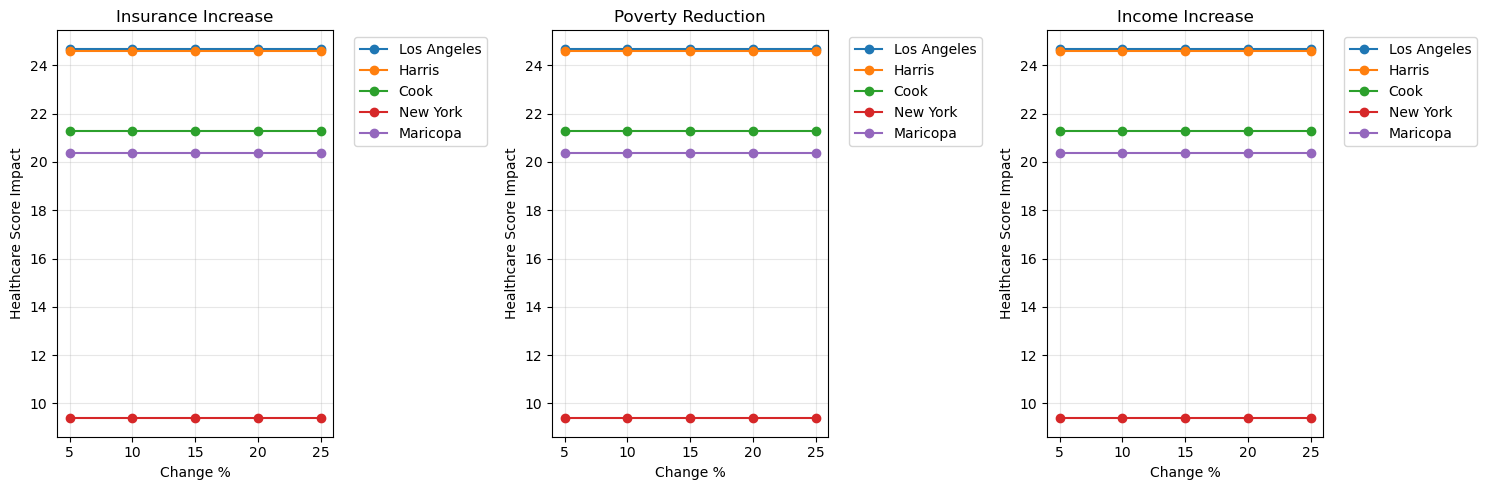

Average impact by intervention type (20% change):
intervention
Income Increase       20.064086
Insurance Increase    20.064086
Poverty Reduction     20.064086
Name: score_impact, dtype: float64


In [11]:
# test different intervention magnitudes
test_counties = ['06037', '48201', '17031', '36061', '04013']  # major metro areas
interventions = [5, 10, 15, 20, 25]  # percentage changes

impact_analysis = []

for county_fips in test_counties:
    county_name = df_health[df_health['FIPS'] == county_fips]['County'].iloc[0]
    state_name = df_health[df_health['FIPS'] == county_fips]['State'].iloc[0]
    
    for change in interventions:
        # test all three policy types
        ins_result = simulate_insurance_change(county_fips, change)
        pov_result = simulate_poverty_change(county_fips, -change)  # poverty reduction
        inc_result = simulate_income_change(county_fips, change)
        
        impact_analysis.extend([
            {
                'county': f"{county_name}, {state_name}",
                'fips': county_fips,
                'intervention': 'Insurance Increase',
                'change_pct': change,
                'score_impact': ins_result['score_change']
            },
            {
                'county': f"{county_name}, {state_name}",
                'fips': county_fips,
                'intervention': 'Poverty Reduction',
                'change_pct': change,
                'score_impact': pov_result['score_change']
            },
            {
                'county': f"{county_name}, {state_name}",
                'fips': county_fips,
                'intervention': 'Income Increase',
                'change_pct': change,
                'score_impact': inc_result['score_change']
            }
        ])

impact_df = pd.DataFrame(impact_analysis)

# plot impact comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, intervention in enumerate(['Insurance Increase', 'Poverty Reduction', 'Income Increase']):
    subset = impact_df[impact_df['intervention'] == intervention]
    
    for county in subset['county'].unique():
        county_data = subset[subset['county'] == county]
        axes[i].plot(county_data['change_pct'], county_data['score_impact'], marker='o', label=county.split(',')[0])
    
    axes[i].set_title(intervention)
    axes[i].set_xlabel('Change %')
    axes[i].set_ylabel('Healthcare Score Impact')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# summary stats
print("Average impact by intervention type (20% change):")
impact_20 = impact_df[impact_df['change_pct'] == 20].groupby('intervention')['score_impact'].mean()
print(impact_20.sort_values(ascending=False))

Regional impact of 15% insurance increase:
      region  avg_impact  counties_tested
1  Southeast   49.720963               50
2    Midwest   48.240201               50
3  Southwest   44.374402               50
4       West   43.336287               50
0  Northeast   39.147734               50


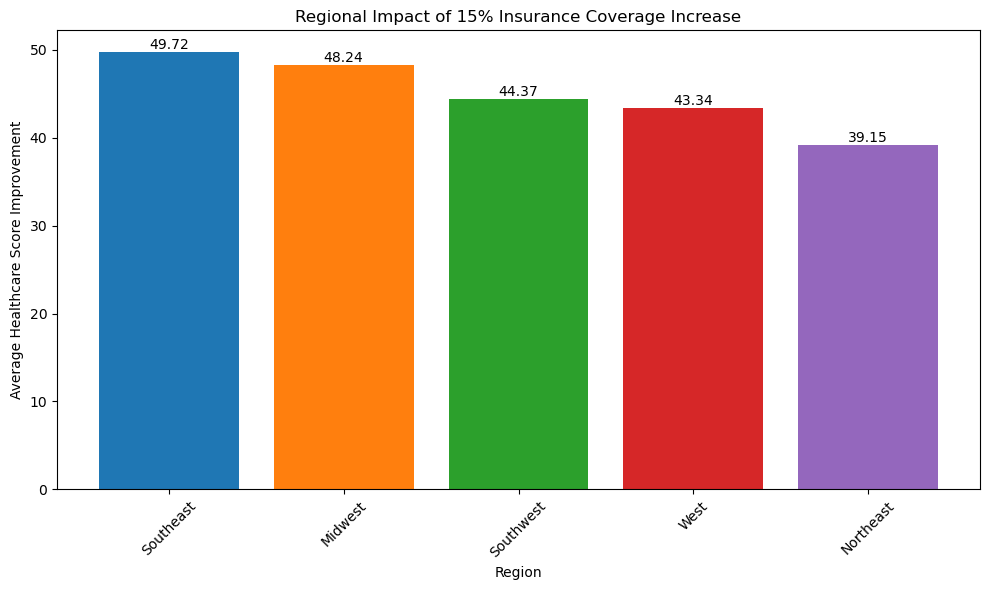

In [12]:
# regional analysis - which regions benefit most from different policies?
region_mapping = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 
                 'New Jersey', 'New York', 'Pennsylvania'],
    'Southeast': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 
                 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 
                 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'Midwest': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 
               'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'Southwest': ['Arizona', 'New Mexico', 'Nevada', 'Utah'],
    'West': ['Alaska', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 'Oregon', 'Washington', 'Wyoming']
}

# create region column
def get_region(state):
    for region, states in region_mapping.items():
        if state in states:
            return region
    return 'Other'

df_health['Region'] = df_health['State'].apply(get_region)

# test 15% insurance increase across all regions
regional_impact = []

for region in region_mapping.keys():
    region_counties = df_health[df_health['Region'] == region].sample(min(50, len(df_health[df_health['Region'] == region])), random_state=42)
    
    impacts = []
    for _, county in region_counties.iterrows():
        result = simulate_insurance_change(county['FIPS'], 15)
        impacts.append(result['score_change'])
    
    regional_impact.append({
        'region': region,
        'avg_impact': np.mean(impacts),
        'counties_tested': len(impacts)
    })

regional_df = pd.DataFrame(regional_impact).sort_values('avg_impact', ascending=False)
print("Regional impact of 15% insurance increase:")
print(regional_df)

# plot regional comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(regional_df['region'], regional_df['avg_impact'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Regional Impact of 15% Insurance Coverage Increase')
plt.xlabel('Region')
plt.ylabel('Average Healthcare Score Improvement')
plt.xticks(rotation=45)

# add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
# estimate policy costs (very rough estimates)
def estimate_policy_cost(county_fips, policy_type, change_pct):
    """rough cost estimates for different policies"""
    county = df_health[df_health['FIPS'] == county_fips].iloc[0]
    population = county['Population']
    
    if policy_type == 'insurance':
        # assume $3000 per person per year for coverage expansion
        uninsured = population * (100 - county['Insurance_Rate']) / 100
        newly_covered = uninsured * (change_pct / 100)
        annual_cost = newly_covered * 3000
        
    elif policy_type == 'poverty':
        # assume $2000 per person in poverty for reduction programs  
        in_poverty = population * county['Poverty_Rate'] / 100
        people_helped = in_poverty * (abs(change_pct) / 100)
        annual_cost = people_helped * 2000
        
    elif policy_type == 'income':
        # assume economic development costs - $500 per person for job programs
        annual_cost = population * 500 * (change_pct / 100)
    
    return annual_cost

# cost-effectiveness for major metros
major_metros = {
    '06037': 'Los Angeles, CA',
    '48201': 'Harris (Houston), TX', 
    '17031': 'Cook (Chicago), IL',
    '36061': 'New York, NY',
    '04013': 'Maricopa (Phoenix), AZ'
}

cost_effectiveness = []

for fips, name in major_metros.items():
    for policy in ['insurance', 'poverty', 'income']:
        change = 15 if policy != 'poverty' else -15
        
        if policy == 'insurance':
            impact = simulate_insurance_change(fips, change)['score_change']
        elif policy == 'poverty':
            impact = simulate_poverty_change(fips, change)['score_change'] 
        elif policy == 'income':
            impact = simulate_income_change(fips, change)['score_change']
            
        cost = estimate_policy_cost(fips, policy, abs(change))
        population = df_health[df_health['FIPS'] == fips]['Population'].iloc[0]
        
        cost_effectiveness.append({
            'county': name,
            'policy': policy,
            'impact': impact,
            'cost_millions': cost / 1e6,
            'cost_per_person': cost / population,
            'impact_per_million': impact / (cost / 1e6) if cost > 0 else 0
        })

ce_df = pd.DataFrame(cost_effectiveness)

# show results
print("Cost-Effectiveness Analysis (15% change):")
print(ce_df.pivot_table(index='county', columns='policy', values='impact_per_million', aggfunc='mean').round(3))

print("\nAverage impact per $1M invested by policy type:")
print(ce_df.groupby('policy')['impact_per_million'].mean().sort_values(ascending=False).round(3))

Cost-Effectiveness Analysis (15% change):
policy                  income  insurance  poverty
county                                            
Cook (Chicago), IL       0.055      1.061    0.103
Harris (Houston), TX     0.069      2.031    0.108
Los Angeles, CA          0.033      0.786    0.061
Maricopa (Phoenix), AZ   0.060      1.108    0.134
New York, NY             0.077      2.546    0.121

Average impact per $1M invested by policy type:
policy
insurance    1.506
poverty      0.106
income       0.059
Name: impact_per_million, dtype: float64


Top 10 opportunity counties for insurance expansion:
                    county  current_score  impact  cost_millions  \
4           Madison, Idaho          44.70   55.30           0.15   
7        Newaygo, Michigan          48.59   51.41           0.27   
1       Tehama, California          48.56   51.44           0.28   
12  Carroll, New Hampshire          54.20   45.80           0.25   
10         Logan, Oklahoma          50.93   49.07           0.28   
0        Franklin, Vermont          50.43   49.57           0.36   
6             Warren, Iowa          52.46   47.54           0.38   
5             Coos, Oregon          46.43   53.57           0.45   
15       Carter, Tennessee          46.30   53.70           0.50   
2          Walker, Alabama          47.02   52.98           0.52   

    impact_per_million  
4               377.75  
7               190.39  
1               186.79  
12              183.96  
10              174.01  
0               138.85  
6               125.36 

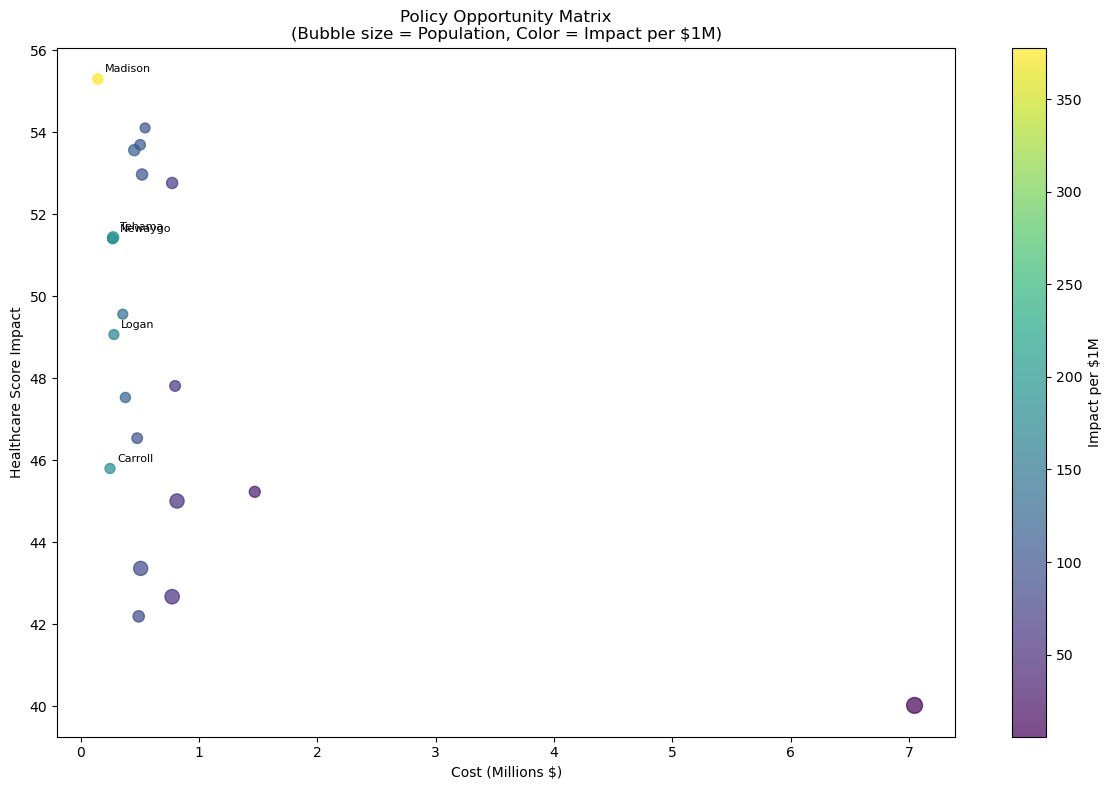

In [14]:
# identify high-opportunity counties - low cost, high impact
opportunity_analysis = []

# sample rural and small metro counties for opportunity analysis
opportunity_counties = df_health[
    (df_health['Population'].between(50000, 500000)) & 
    (df_health['Healthcare_Access'] < 60)  # below average access
].sample(20, random_state=42)

for _, county in opportunity_counties.iterrows():
    fips = county['FIPS']
    
    # test insurance expansion impact
    ins_impact = simulate_insurance_change(fips, 20)['score_change']
    ins_cost = estimate_policy_cost(fips, 'insurance', 20)
    
    opportunity_analysis.append({
        'county': f"{county['County']}, {county['State']}",
        'current_score': county['Healthcare_Access'],
        'population': county['Population'],
        'impact': ins_impact,
        'cost_millions': ins_cost / 1e6,
        'impact_per_million': ins_impact / (ins_cost / 1e6) if ins_cost > 0 else 0
    })

opp_df = pd.DataFrame(opportunity_analysis).sort_values('impact_per_million', ascending=False)

print("Top 10 opportunity counties for insurance expansion:")
print(opp_df.head(10)[['county', 'current_score', 'impact', 'cost_millions', 'impact_per_million']].round(2))

# plot opportunity matrix
plt.figure(figsize=(12, 8))
scatter = plt.scatter(opp_df['cost_millions'], opp_df['impact'], 
                     c=opp_df['impact_per_million'], s=opp_df['population']/1000, 
                     alpha=0.7, cmap='viridis')

plt.xlabel('Cost (Millions $)')
plt.ylabel('Healthcare Score Impact')
plt.title('Policy Opportunity Matrix\n(Bubble size = Population, Color = Impact per $1M)')

# add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Impact per $1M')

# annotate top opportunities
top_5 = opp_df.head(5)
for _, row in top_5.iterrows():
    plt.annotate(row['county'].split(',')[0], 
                (row['cost_millions'], row['impact']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

## Export Data for Frontend

preparing all the data structures the frontend will need

In [15]:
# create master dataset with all necessary fields for frontend
frontend_data = df_health[[
    'FIPS', 'County', 'State', 'Region', 'Population', 
    'Median_Income', 'Healthcare_Access', 'Insurance_Rate',
    'Education_Rate', 'Poverty_Rate', 'No_Vehicle_Rate',
    'Disability_Rate', 'LEP_Rate', 'Broadband_Rate',
    'Cluster', 'Cluster_Name'
]].copy()

# add lat/lon for mapping (approximate county centroids)
# this is simplified - in real frontend would use proper geocoding
frontend_data['Lat'] = frontend_data['State'].map({
    'California': 36.7783, 'Texas': 31.9686, 'Florida': 27.7663,
    'New York': 40.7589, 'Pennsylvania': 40.2677, 'Illinois': 40.6331,
    'Ohio': 40.2732, 'Georgia': 32.1656, 'North Carolina': 35.7596,
    'Michigan': 44.3148, 'New Jersey': 40.0583, 'Virginia': 37.4316,
    'Washington': 47.7511, 'Arizona': 34.0489, 'Massachusetts': 42.2373,
    'Tennessee': 35.5175, 'Indiana': 40.2677, 'Missouri': 37.9643,
    'Maryland': 39.0458, 'Wisconsin': 43.7844, 'Colorado': 39.7392,
    'Minnesota': 46.7296, 'South Carolina': 33.8361, 'Alabama': 32.3182,
    'Louisiana': 30.9843, 'Kentucky': 37.8393, 'Oregon': 44.9778,
    'Oklahoma': 35.0078, 'Connecticut': 41.6032, 'Iowa': 41.8780,
    'Arkansas': 34.7465, 'Mississippi': 32.3547, 'Kansas': 39.0119,
    'Utah': 39.3210, 'Nevada': 38.8026, 'New Mexico': 34.5199,
    'West Virginia': 38.5976, 'Nebraska': 41.4925, 'Idaho': 44.0682,
    'Hawaii': 19.8968, 'New Hampshire': 43.1939, 'Maine': 45.2538,
    'Rhode Island': 41.5801, 'Montana': 46.8797, 'Delaware': 38.9108,
    'South Dakota': 43.9695, 'North Dakota': 47.5515, 'Alaska': 64.0685,
    'Vermont': 44.2601, 'Wyoming': 43.0750, 'District of Columbia': 38.9072
})

frontend_data['Lng'] = frontend_data['State'].map({
    'California': -119.4179, 'Texas': -99.9018, 'Florida': -82.6404,
    'New York': -73.9851, 'Pennsylvania': -76.8759, 'Illinois': -89.3985,
    'Ohio': -82.7850, 'Georgia': -82.9001, 'North Carolina': -79.0193,
    'Michigan': -85.6024, 'New Jersey': -74.4057, 'Virginia': -78.6569,
    'Washington': -120.7401, 'Arizona': -111.0937, 'Massachusetts': -71.5314,
    'Tennessee': -86.5804, 'Indiana': -86.1349, 'Missouri': -91.8318,
    'Maryland': -76.6413, 'Wisconsin': -88.7879, 'Colorado': -104.9903,
    'Minnesota': -94.6859, 'South Carolina': -81.1637, 'Alabama': -86.9023,
    'Louisiana': -91.9623, 'Kentucky': -84.2700, 'Oregon': -120.7376,
    'Oklahoma': -97.0929, 'Connecticut': -73.0877, 'Iowa': -93.0977,
    'Arkansas': -92.2824, 'Mississippi': -89.3985, 'Kansas': -98.4842,
    'Utah': -111.0937, 'Nevada': -116.4194, 'New Mexico': -105.8701,
    'West Virginia': -80.4549, 'Nebraska': -99.9018, 'Idaho': -114.7420,
    'Hawaii': -155.5828, 'New Hampshire': -71.5724, 'Maine': -69.4455,
    'Rhode Island': -71.4774, 'Montana': -110.3626, 'Delaware': -75.5277,
    'South Dakota': -99.9018, 'North Dakota': -101.0020, 'Alaska': -152.2782,
    'Vermont': -72.5806, 'Wyoming': -107.2903, 'District of Columbia': -77.0369
})

# add small random jitter to avoid overlapping counties
np.random.seed(42)
frontend_data['Lat'] += np.random.normal(0, 0.3, len(frontend_data))
frontend_data['Lng'] += np.random.normal(0, 0.4, len(frontend_data))

# clean up data
frontend_data = frontend_data.fillna(0)
# frontend_data = frontend_data.round(2)

print(f"Frontend dataset: {len(frontend_data)} counties with {len(frontend_data.columns)} features")
print("\nSample data:")
print(frontend_data.head(3))

# save to files
frontend_data.to_json('results/public/county_data.json', orient='records', indent=2)
frontend_data.to_csv('.objects/county_data.csv', index=False)
print("\nData exported to county_data.json and county_data.csv")

Frontend dataset: 3222 counties with 18 features

Sample data:
    FIPS   County    State     Region  Population  Median_Income  \
0  01001  Autauga  Alabama  Southeast     59285.0        69841.0   
1  01003  Baldwin  Alabama  Southeast    239945.0        75019.0   
2  01005  Barbour  Alabama  Southeast     24757.0        44290.0   

   Healthcare_Access  Insurance_Rate  Education_Rate  Poverty_Rate  \
0          52.181449       97.753226       10.994349     10.684306   
1          69.242195       98.649274       14.731709     10.514699   
2          42.714216       87.591388        4.762289     21.921478   

   No_Vehicle_Rate  Disability_Rate  LEP_Rate  Broadband_Rate  Cluster  \
0         3.765040        47.762842       0.0         20469.0        5   
1         2.154435        48.447006      25.0         84942.0        0   
2        11.112335        45.930367       0.0          6565.0        3   

          Cluster_Name        Lat        Lng  
0  Rural Disadvantaged  32.467214 -86.3

In [16]:
# create state summaries for frontend
state_summary = frontend_data.groupby(['State', 'Region']).agg({
    'Population': 'sum',
    'Healthcare_Access': 'mean',
    'Insurance_Rate': 'mean',
    'Poverty_Rate': 'mean',
    'Education_Rate': 'mean',
    'Median_Income': 'mean',
    'County': 'count'
}).round(2).reset_index()

state_summary = state_summary.rename(columns={'County': 'County_Count'})

print("State summaries:")
print(state_summary.head())

state_summary.to_json('results/public/state_summary.json', orient='records', indent=2)

# create cluster profiles for frontend
cluster_profiles = frontend_data.groupby(['Cluster', 'Cluster_Name']).agg({
    'Population': ['mean', 'count'],
    'Healthcare_Access': 'mean',
    'Insurance_Rate': 'mean',
    'Poverty_Rate': 'mean',
    'Education_Rate': 'mean',
    'Median_Income': 'mean'
}).round(2)

cluster_profiles.columns = ['Avg_Population', 'County_Count', 'Avg_Healthcare_Access', 
                           'Avg_Insurance_Rate', 'Avg_Poverty_Rate', 'Avg_Education_Rate', 'Avg_Median_Income']
cluster_profiles = cluster_profiles.reset_index()

cluster_profiles.to_json('results/public/cluster_profiles.json', orient='records', indent=2)
print("\nCluster profiles exported to .objects/cluster_profiles.json")
print(cluster_profiles)

State summaries:
        State     Region  Population  Healthcare_Access  Insurance_Rate  \
0     Alabama  Southeast   5054253.0              49.57           97.85   
1      Alaska       West    733971.0              51.61           97.95   
2     Arizona  Southwest   7268175.0              57.47           97.65   
3    Arkansas  Southeast   3032651.0              47.26           97.42   
4  California       West  39242785.0              65.12           97.90   

   Poverty_Rate  Education_Rate  Median_Income  County_Count  
0         18.44            8.31       54195.84            67  
1         11.94           10.86       79407.33            30  
2         17.09            9.91       62662.60            15  
3         18.47            8.01       51155.93            75  
4         12.85           13.03       87001.14            58  

Cluster profiles exported to .objects/cluster_profiles.json
   Cluster           Cluster_Name  Avg_Population  County_Count  \
0        0       Rural Low

In [17]:
# save models for frontend predictions
import joblib

# save the trained models
joblib.dump(rf_insurance, '.objects/insurance_model.pkl')
joblib.dump(rf_poverty, '.objects/poverty_model.pkl')
joblib.dump(rf_education, '.objects/education_model.pkl')
joblib.dump(rf_income, '.objects/income_model.pkl')
# joblib.dump(rf_optimized, '.objects/healthcare_model.pkl')
joblib.dump(scaler, '.objects/scaler.pkl')
joblib.dump(kmeans_final, '.objects/cluster_model.pkl')

print("Models saved for frontend integration")

# create model metadata
model_info = {
    'insurance_model': {
        'features': insurance_features,
        'mae': round(mean_absolute_error(y_ins_test, ins_pred), 2),
        'r2': round(r2_score(y_ins_test, ins_pred), 3)
    },
    'poverty_model': {
        'features': poverty_features,
        'mae': round(mean_absolute_error(y_pov_test, pov_pred), 2),
        'r2': round(r2_score(y_pov_test, pov_pred), 3)
    },
    'education_model': {
        'features': education_features,
        'mae': round(mean_absolute_error(y_edu_test, edu_pred), 2),
        'r2': round(r2_score(y_edu_test, edu_pred), 3)
    },
    'income_model': {
        'features': income_features,
        'mae': round(mean_absolute_error(y_inc_test, inc_pred), 0),
        'r2': round(r2_score(y_inc_test, inc_pred), 3)
    }
}

import json
with open('results/public/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("\nModel information:")
for model, info in model_info.items():
    print(f"{model}: MAE={info['mae']}, R²={info['r2']}")

Models saved for frontend integration

Model information:
insurance_model: MAE=2.03, R²=0.104
poverty_model: MAE=2.23, R²=0.819
education_model: MAE=2.2, R²=0.531
income_model: MAE=5727.0, R²=0.82


In [18]:
# final validation - test the simulation functions work correctly
print("=== Final Validation ===")

# test random counties
test_counties = frontend_data.sample(5, random_state=42)

print("\nSimulation function tests:")
for _, county in test_counties.iterrows():
    name = f"{county['County']}, {county['State']}"
    fips = county['FIPS']
    
    # test insurance simulation
    result = simulate_insurance_change(fips, 10)
    print(f"{name}: +10% insurance → {result['score_change']:+.1f} points")

print(f"\nData files created:")
print(f"- county_data.json ({len(frontend_data)} counties)")
print(f"- county_data.csv ({len(frontend_data)} counties)")
print(f"- state_summary.json ({len(state_summary)} states)")
print(f"- cluster_profiles.json ({len(cluster_profiles)} clusters)")
print(f"- model_info.json (4 models)")
print(f"- 7 .pkl model files")

print(f"\n✓ Analysis phase complete - ready for frontend development!")

=== Final Validation ===

Simulation function tests:
Routt, Colorado: +10% insurance → +49.4 points
Pierce, Georgia: +10% insurance → +56.3 points
Hardin, Illinois: +10% insurance → +53.7 points
Mercer, Ohio: +10% insurance → +50.3 points
Ramsey, Minnesota: +10% insurance → +29.0 points

Data files created:
- county_data.json (3222 counties)
- county_data.csv (3222 counties)
- state_summary.json (52 states)
- cluster_profiles.json (7 clusters)
- model_info.json (4 models)
- 7 .pkl model files

✓ Analysis phase complete - ready for frontend development!
Mercer, Ohio: +10% insurance → +50.3 points
Ramsey, Minnesota: +10% insurance → +29.0 points

Data files created:
- county_data.json (3222 counties)
- county_data.csv (3222 counties)
- state_summary.json (52 states)
- cluster_profiles.json (7 clusters)
- model_info.json (4 models)
- 7 .pkl model files

✓ Analysis phase complete - ready for frontend development!
